In [530]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import seaborn as sns

In [560]:
# set the parameters
seeds = [3, 3, 3]

# number of periods
T = 15

# number of trials
be_trials = 10

# alpha threshold for the switcher 
# (this will be estimated bu maximum likelihood from the data on the tables they are choosing to see)
a = 1.1

# base rate neglect (taken from Drobner and Goerg, 2022)
d = .87

# self-serving bias (overweight positive signals and underweight negative ones when updating on type and 
# do the opposite when updating on the exogenour parameter, also taken from Drobner and Goerg for now)
c_theta_positive = 1.5
c_theta_negative = .3
c_omega_positive = .3
c_omega_negative = 1.5

attributions = [c_theta_positive, c_theta_negative, c_omega_positive, c_omega_negative]

In [561]:
# matrices: matrix[0] is the low type, matrix[2] is the high type. column 0 is low omega, row 0 is low effort
ml = np.array([[.20, .25, .40], [.07, .30, .45], [.02, .20, .50]])
mm = np.array([[.40, .45, .65], [.30, .65, .69], [.05, .50, .80]])
mh = np.array([[.45, .55, .75], [.35, .69, .80], [.25, .65, .98]])

msc = [ml, mm, mh]


$\pi_{t+1}[\theta_h|s]=\frac{P[s|\theta_H]^c\pi_{t}[\theta_H]^d}{P[s|\theta_H]^c\pi_{t}[\theta_H]^d+P[s|\theta_M]^c\pi_{t}[\theta_M]^d+P[s|\theta_L]^c\pi_{t}[\theta_L]^d}$

with $c = c_g^\theta$ if the signal is good and $c=c_b^\theta$ if the signal is bad

the signal is good if there are half or more successes and it is bad if there are fewer than half successes and $c_g^\theta > c_b^\theta$ 

To update $\omega$ it is analogous with the corresponding values of c.

In [562]:
# generalized bayes update: if the bias parameters are all 1, it is bayes, if d is less than one it is base rate-neglect
# if c is not all ones, it is attribution bias.
def bayes_biases(c, brn, p0_theta, p0_omega, signal, M, e_index):
    # c is the vector of attribution biases [theta_positive, theta_negative, omega_positive, omega_negative]
    # brn is the base rate neglect parameter
    # p0 are the priors
    # the signal is a binary vector of length be_trials 
    # M is the 3 matrices with the probabilitites of success conditional on each of the values of theta and omega
    # e_index is the effort level chosen in the round
    
    # nuber of sucesses
    k = sum(signal)
    n = len(signal)
    # set the exponents for the bias
    if k>=n/2:
        c_theta = c[0]
        c_omega = c[2]
    else:
        c_theta = c[1]
        c_omega = c[3]
    # matrix with all the probabilities (the row corresponding to e_index) stacked by theta
    matrix = np.array([sp.stats.binom.pmf(k, n, M[0][e_index, :], loc=0), 
                       sp.stats.binom.pmf(k, n, M[1][e_index, :], loc=0), 
                       sp.stats.binom.pmf(k, n, M[2][e_index, :], loc=0)])
    
    # The first term in the numerator 
    p_omega = np.power(p0_theta@matrix, c_omega)
    p_theta = np.power(matrix@p0_omega, c_theta)
     
    # multiply by the prior to the brn to get the 3 numerators
    num_omega = np.diag( np.diagflat(p_omega) @ np.power(np.diagflat(p0_omega), brn) )
    num_theta = np.diag( np.diagflat(p_theta) @ np.power(np.diagflat(p0_theta), brn) )
    
    # denominator is the sum of the numerators
    denom_o = np.sum(num_omega)
    denom_th = np.sum(num_theta)
    
    # the posterior beiefs
    p1_omega = num_omega/denom_o
    p1_theta = num_theta/denom_th
    
    # save the likelihoods for theta in a vector with [H/M, M/L, H/L]
    likelihoods = [num_theta[2]/num_theta[1], num_theta[1]/num_theta[0], num_theta[2]/num_theta[0]]

        
    return p1_theta, p1_omega, likelihoods
    
    

In [563]:
def update_dog(prior, type_belief, signal, M, e_index):
    k = sum(signal)
    n = len(signal)
    
    p = sp.stats.binom.pmf(k, n, M[type_belief][e_index, :], loc=0)
    
    num = np.diag(np.diagflat(prior)@np.diagflat(p))
    denom = sum(num)
    
    posterior = num/denom
    
    return posterior
    
    

In [564]:
def update_lr(prior, type_belief, signal, M, e_index):
    k = sum(signal)
    n = len(signal)
    
    p = sp.stats.binom.pmf(k, n, M[type_belief][e_index, :], loc=0)
    
    num = np.diag(np.diagflat(prior)@np.diagflat(p))
    denom = sum(num)
    
    posterior = num/denom
    
    likelihoods = [num[0], num[1], num[2]]
    
    return posterior, likelihoods

In [565]:
# a function that chooses a level of effort for the dogmatic and the switcher
def choice_dog(prior, type_belief, M):
    # type belief should be 0, 1, or 2
    # the prior is over omegas. 
    # M is a vector of the three probability matrices (L, M, H)
    # calculate the expected utility from each choice
    Eu = np.dot(M[type_belief], prior)
    # element that maximizes the flow utility is the choice
    e_index = np.argmax(Eu)
    
    return e_index

In [566]:
# a function that chooses the level of effort for the bayesian and the self-serving
def choice_bay(p0_theta, p0_omega, M):
    # expected utility consitional on each type and each choice
    Eu_theta = [np.dot(M[0], p0_omega), np.dot(M[1], p0_omega), np.dot(M[2], p0_omega)]
    # Expected utility conditional only on choices
    Eu = np.dot(np.transpose(Eu_theta), p0_theta)
    e_index = np.argmax(Eu) 
    
    return e_index

In [567]:
def simulate(theta, omega, p0_theta, p0_omega, M, c, d, T, N, trials, seeds, a):
    
    ###### Determine the outcomes beforehand
    # set a seed for each type
    rng_H = np.random.default_rng(seed=seeds[0])
    rng_M = np.random.default_rng(seed=seeds[1])
    rng_L = np.random.default_rng(seed=seeds[2])

    #############
    # generate all the draws for T periods for each type and for each effort choice
    ############

    ##### for the high types
    # outcomes after choosing L
    outcome_H_L = rng_H.binomial(1, M[2][0, omega], size=(T, be_trials))
    # outcomes after choosing M
    outcome_H_M = rng_H.binomial(1, M[2][1, omega], size=(T, be_trials))
    # outcomes after choosing H
    outcome_H_H = rng_H.binomial(1, M[2][2, omega], size=(T, be_trials))

    ##### for the medium types
    # after low effort
    outcome_M_L = rng_M.binomial(1, M[1][0, omega], size=(T, be_trials))
    # after medium effort
    outcome_M_M = rng_M.binomial(1, M[1][1, omega], size=(T, be_trials))
    # after high effort
    outcome_M_H = rng_M.binomial(1, M[1][2, omega], size=(T, be_trials))

    #### for the low types
    outcomes_L_L = rng_L.binomial(1, M[0][0, omega], size=(T, be_trials))
    outcomes_L_M = rng_L.binomial(1, M[0][1, omega], size=(T, be_trials))
    outcomes_L_H = rng_L.binomial(1, M[0][2, omega], size=(T, be_trials))

    # stack the outcome vectors foe each type into a matrix. first element is the effort choice, secod is t
    outcomes_H = np.stack((outcome_H_L, outcome_H_M, outcome_H_H))
    outcomes_M = np.stack((outcome_M_L, outcome_M_M, outcome_M_H))
    outcomes_L = np.stack((outcomes_L_L, outcomes_L_M, outcomes_L_H))

    # stack all the matrices into a single outcomes matrix of matrices
    outcomes = np.stack((outcomes_L, outcomes_M, outcomes_H))
    
    
    #############
    # set empty vectors where all the data will be saved period by period for each of the models
    ############
    # beliefs
    p_theta_bay =[p0_theta]
    p_omega_bay = [p0_omega]
    
    p_theta_ss =[p0_theta]
    p_omega_ss = [p0_omega]
    
    p_theta_dog_L =[0]
    p_theta_dog_M =[1]
    p_theta_dog_H =[2]
    p_omega_dog_H = [p0_omega]
    p_omega_dog_M = [p0_omega]
    p_omega_dog_L = [p0_omega]
    
    theta_lr_L =[0]
    theta_lr_M =[1]
    theta_lr_H =[2]
    p_omega_lr_H = [p0_omega]
    p_omega_lr_M = [p0_omega]
    p_omega_lr_L = [p0_omega]
    
    # choices
    e_bay = [choice_bay(p0_theta, p0_omega, M)]
    
    e_ss = [choice_bay(p0_theta, p0_omega, M)]
    
    e_dog_L = [0]
    e_dog_M = [1]
    e_dog_H = [2]
    
    e_lr_L = [0]
    e_lr_M = [1]
    e_lr_H = [2]
    
    # likelihood theta H/M, M/L, H/L
    likelihoods = [[p0_theta[2]/p0_theta[1], p0_theta[1]/p0_theta[0], p0_theta[2]/p0_theta[0]]]
    
    signals = outcomes[theta]
    
    for t in range(T):
        # get the signals for each model
        signal_dog_H = signals[e_dog_H[t], omega]
        signal_dog_M = signals[e_dog_M[t], omega]
        signal_dog_L = signals[e_dog_L[t], omega]
        
        signal_lr_H = signals[e_lr_H[t], omega]
        signal_lr_M = signals[e_lr_M[t], omega]
        signal_lr_L = signals[e_lr_L[t], omega]
        
        signal_bay = signals[e_bay[t], omega]
        signal_ss = signals[e_ss[t], omega]
        
        # update beliefs for each model and each believed type
        
        ### bayesian
        bay_theta, bay_omega, bay_lr = bayes_biases([1,1,1, 1], 1, p_theta_bay[t], p_omega_bay[t], signal_bay, M, e_bay[t])
        p_theta_bay.append(bay_theta)
        p_omega_bay.append(bay_omega)
        
        ### self-serving
        ss_theta, ss_omega, ss_lr = bayes_biases(c, d, p_theta_ss[t], p_omega_ss[t], signal_ss, M, e_ss[t])
        p_theta_ss.append(ss_theta)
        p_omega_ss.append(ss_omega)
        
        ### likelihood ratio
        omega_lr_H, l_H = update_lr(p_omega_lr_H[t], theta_lr_H[t], signal_lr_H, M, e_lr_H[t])
        omega_lr_M, l_M = update_lr(p_omega_lr_M[t], theta_lr_M[t], signal_lr_M, M, e_lr_M[t])
        omega_lr_L, l_L = update_lr(p_omega_lr_L[t], theta_lr_L[t], signal_lr_L, M, e_lr_L[t])
        
        p_omega_lr_H.append(omega_lr_H)
        p_omega_lr_M.append(omega_lr_M)
        p_omega_lr_L.append(omega_lr_L)
        
        ### dogmatic
        omega_dog_H = update_dog(p_omega_dog_H[t], 2, signal_dog_H, M, e_dog_H[t])
        omega_dog_M = update_dog(p_omega_dog_M[t], 1, signal_dog_M, M, e_dog_M[t])
        omega_dog_L = update_dog(p_omega_dog_L[t], 0, signal_dog_L, M, e_dog_L[t])
        
        p_omega_dog_H.append(omega_dog_H)
        p_omega_dog_M.append(omega_dog_M)
        p_omega_dog_L.append(omega_dog_L)
        
        
        # take the most likely type and check if the likelihood ratio vs the current model is above alpha
        # if it is, set it as the theta for the switcher
        
        H_top = np.argmax(l_H)
        H_current = theta_lr_H[t]
        LR_H = l_H[H_top]/l_H[H_current]
        
        if LR_H >= alpha:
            theta_lr_H.append(H_top)
        else:
            theta_lr_H.append(H_current) 
        
        M_top = np.argmax(l_M)
        M_current = theta_lr_M[t]
        LR_M = l_M[M_top]/l_M[M_current]
        
        if LR_M >= alpha:
            theta_lr_M.append(M_top)
        else:
            theta_lr_M.append(M_current)
            
        L_top = np.argmax(l_L)
        L_current = theta_lr_L[t]
        LR_L = l_L[L_top]/l_L[L_current]
        
        if LR_L >= alpha:
            theta_lr_L.append(L_top)
        else:
            theta_lr_L.append(L_current)
        
        # Choices for each model and each believed type
        e_bay_t = choice_bay(bay_theta, bay_omega, M)
        e_bay.append(e_bay_t)
        
        e_ss_t = choice_bay(ss_theta, ss_omega, M)
        e_ss.append(e_ss_t)
        
        e_dog_H.append(choice_dog(omega_dog_H, 2, M))
        e_dog_M.append(choice_dog(omega_dog_M, 1, M))
        e_dog_L.append(choice_dog(omega_dog_L, 0, M))
        
        e_lr_H.append(choice_dog(omega_lr_H, np.argmax(l_H), M))
        e_lr_M.append(choice_dog(omega_lr_M, np.argmax(l_M), M))
        e_lr_L.append(choice_dog(omega_lr_L, np.argmax(l_L), M))
        
    return [e_lr_L, e_lr_M, e_lr_H, e_dog_L, e_dog_M, e_dog_H, e_bay, e_ss]


In [568]:
choices_00 = simulate(0, 0, [1/3,1/3, 1/3], [1/3,1/3, 1/3], msc, attributions, 1, T, 1, be_trials, [3,3,3], a)
choices_01 = simulate(0, 1, [1/3,1/3, 1/3], [1/3,1/3, 1/3], msc, attributions, 1, T, 1, be_trials, [3,3,3], a)
choices_02 = simulate(0, 2, [1/3,1/3, 1/3], [1/3,1/3, 1/3], msc, attributions, 1, T, 1, be_trials, [3,3,3], a)

choices_10 = simulate(1, 0, [1/3,1/3, 1/3], [1/3,1/3, 1/3], msc, attributions, 1, T, 1, be_trials, [3,3,3], a)
choices_11 = simulate(1, 1, [1/3,1/3, 1/3], [1/3,1/3, 1/3], msc, attributions, 1, T, 1, be_trials, [3,3,3], a)
choices_12 = simulate(1, 2, [1/3,1/3, 1/3], [1/3,1/3, 1/3], msc, attributions, 1, T, 1, be_trials, [3,3,3], a)

choices_20 = simulate(2, 0, [1/3,1/3, 1/3], [1/3,1/3, 1/3], msc, attributions, 1, T, 1, be_trials, [3,3,3], a)
choices_21 = simulate(2, 1, [1/3,1/3, 1/3], [1/3,1/3, 1/3], msc, attributions, 1, T, 1, be_trials, [3,3,3], a)
choices_22 = simulate(2, 2, [1/3,1/3, 1/3], [1/3,1/3, 1/3], msc, attributions, 1, T, 1, be_trials, [3,3,3], a)

In [569]:
def plot(choices, theta, omega):
    
    fig, axs = plt.subplots(3, 3, figsize=(20, 15))
    axs[0,0].plot(choices[0])
    axs[0,1].plot(choices[1])
    axs[0,2].plot(choices[2])
    
    axs[0, 0].set_title('switcher, belief L')
    axs[0, 1].set_title('switcher, belief M')
    axs[0, 2].set_title('switcher, belief H')

    axs[1,0].plot(choices[3])
    axs[1,1].plot(choices[4])
    axs[1,2].plot(choices[5])
    
    axs[1, 0].set_title('dogmatic, belief L')
    axs[1, 1].set_title('dogmatic, belief M')
    axs[1, 2].set_title('dogmatic, belief H')

    axs[2,0].plot(choices[6])
    axs[2,1].plot(choices[7])
    
    axs[2, 0].set_title('Bayesian')
    axs[2, 1].set_title('Self Serving')
    
    axs[0, 0].set_ylim(-0.5, 2.5)
    axs[0, 1].set_ylim(-.5, 2.5)
    axs[0, 2].set_ylim(-.5, 2.5)
    axs[1, 0].set_ylim(-.5, 2.5)
    axs[1, 1].set_ylim(-.5, 2.5)
    axs[1, 2].set_ylim(-.5, 2.5)
    axs[2, 0].set_ylim(-.5, 2.5)
    axs[2, 1].set_ylim(-.5, 2.5)
    axs[2, 2].set_ylim(-.5, 2.5)
    
    fig.suptitle('type = ' + str(theta) + ', rate = '+str(omega))

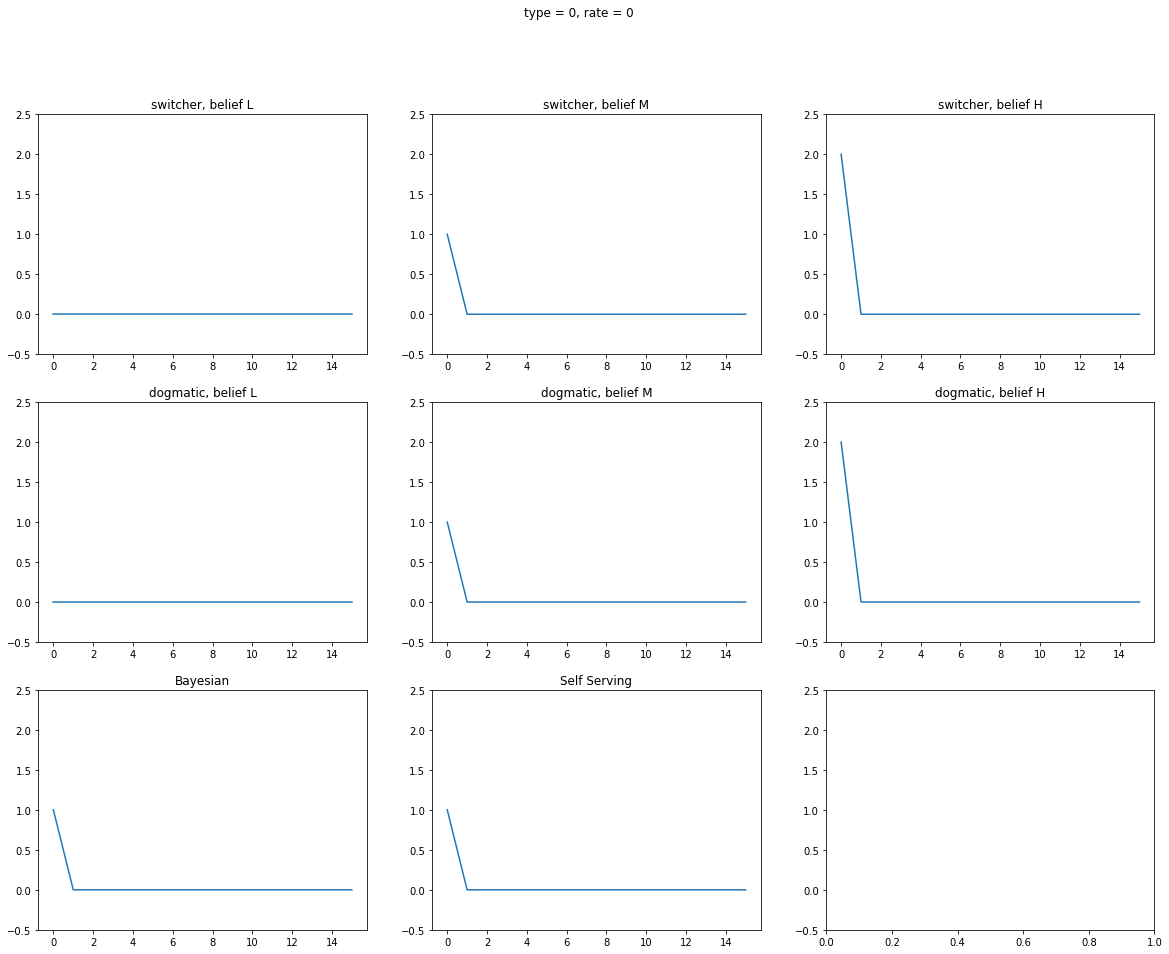

In [570]:
plot(choices_00, 0, 0)



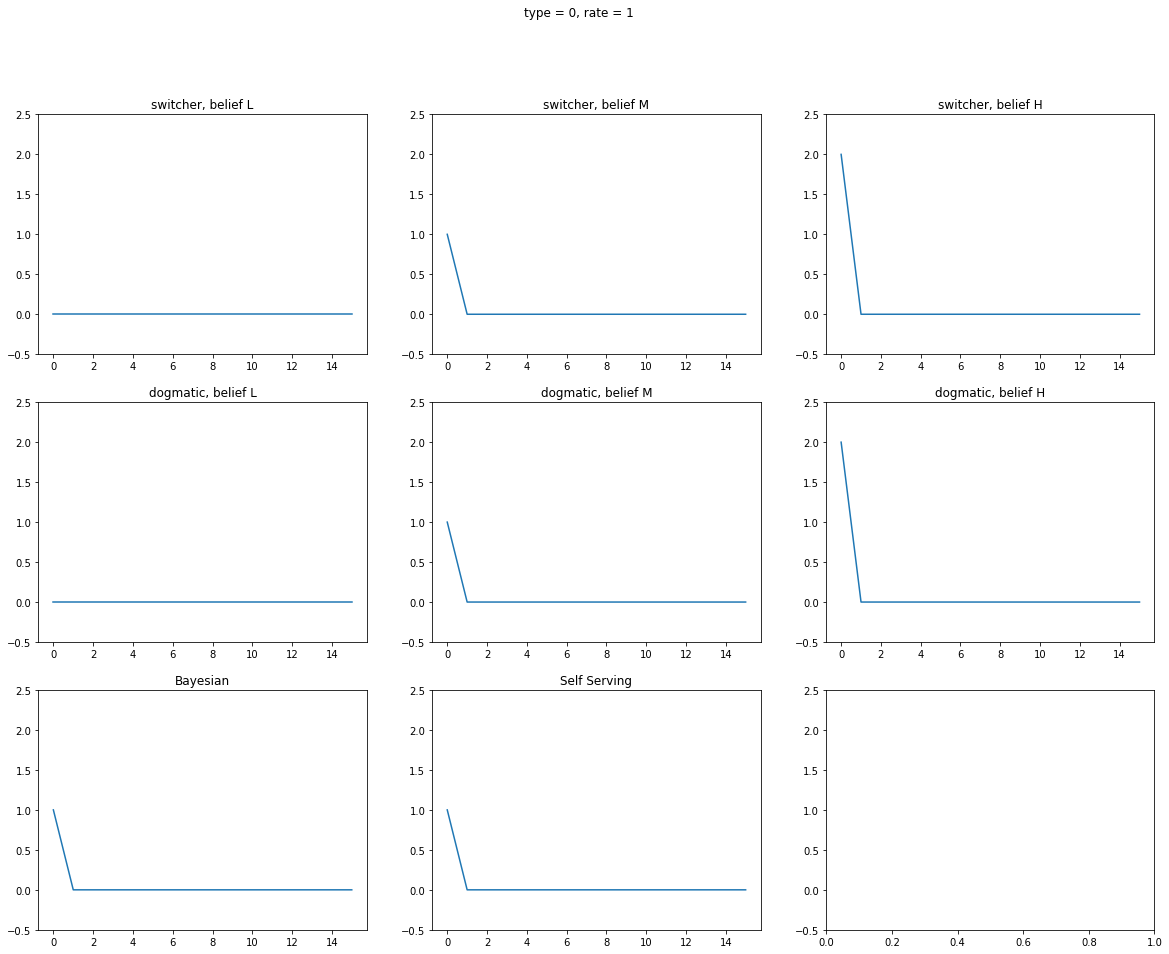

In [571]:
plot(choices_01, 0, 1)


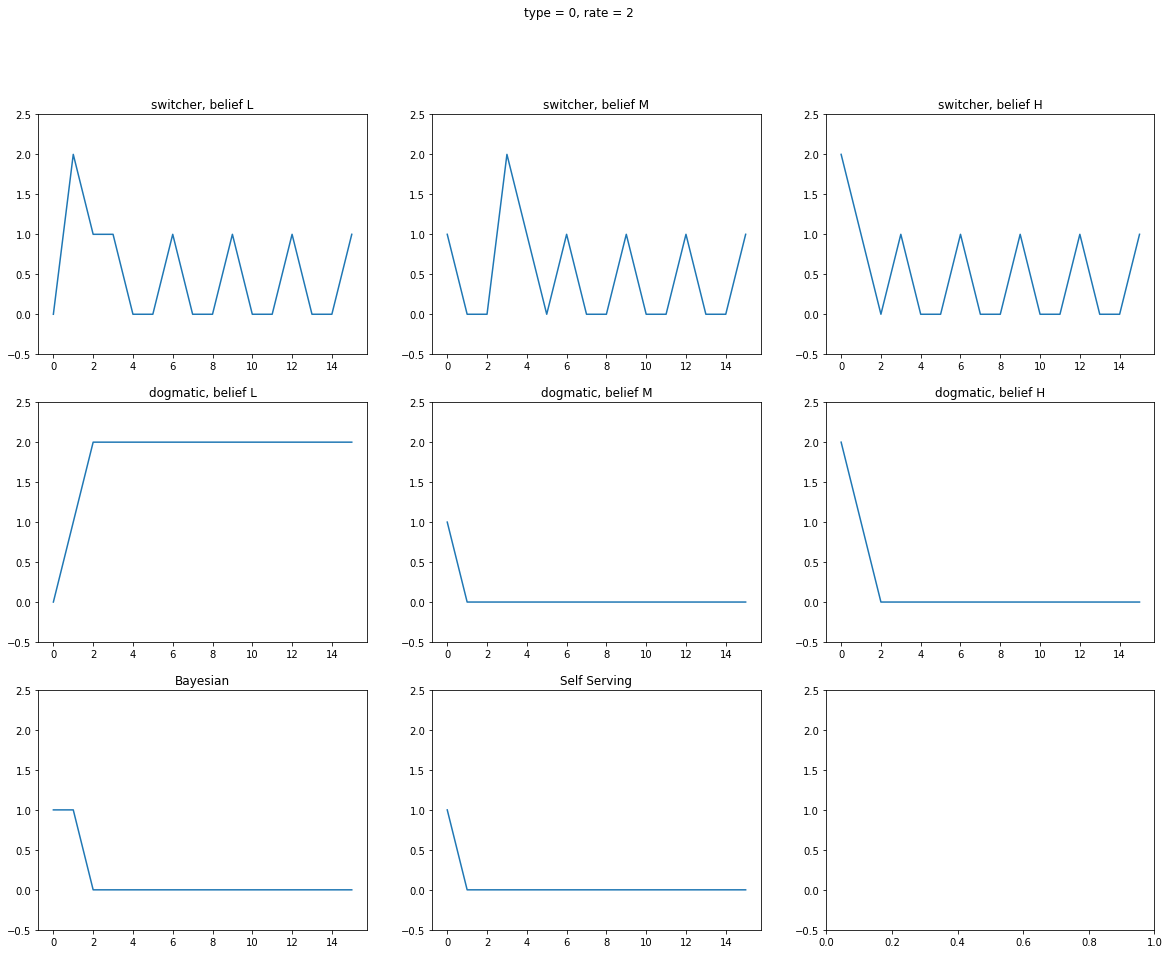

In [572]:
plot(choices_02, 0, 2)


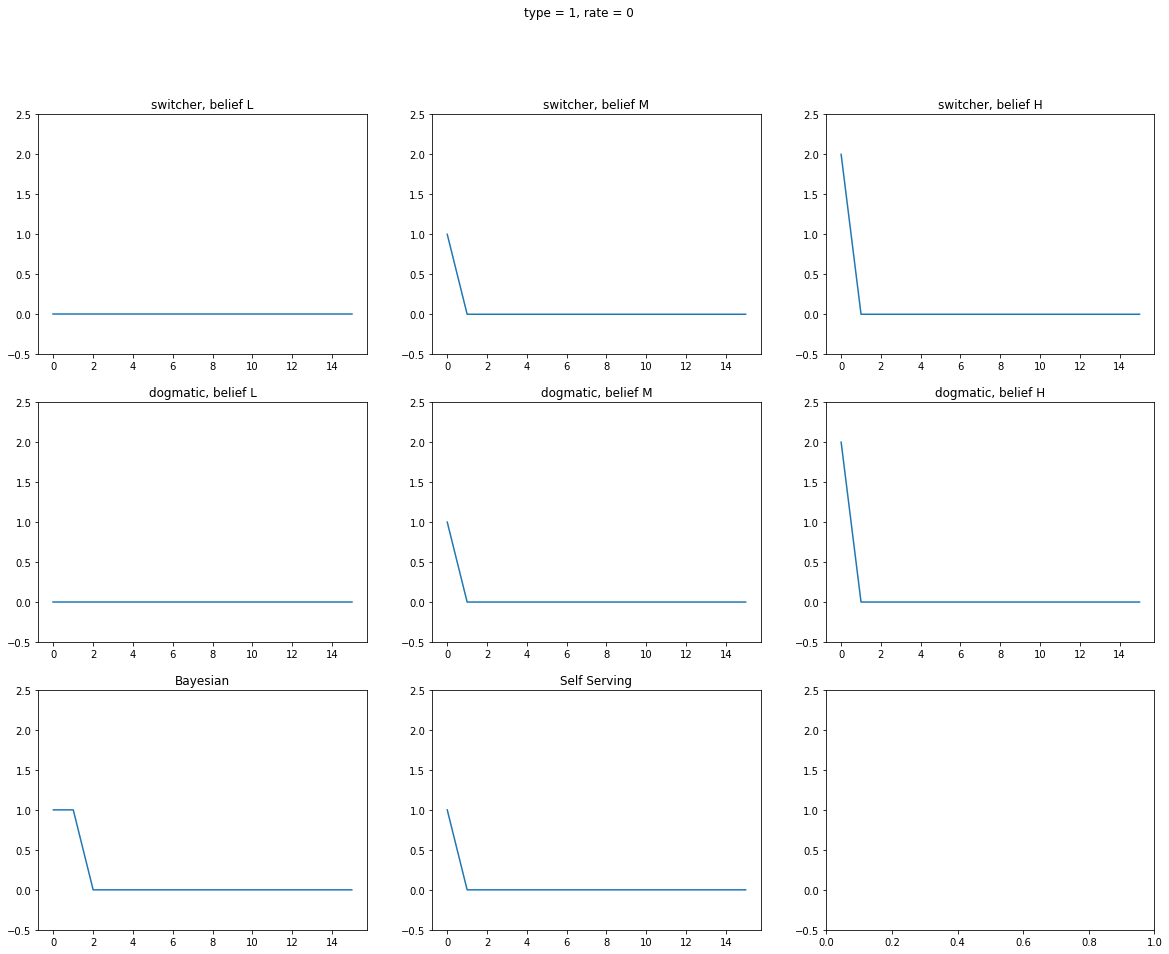

In [573]:
plot(choices_10, 1, 0)


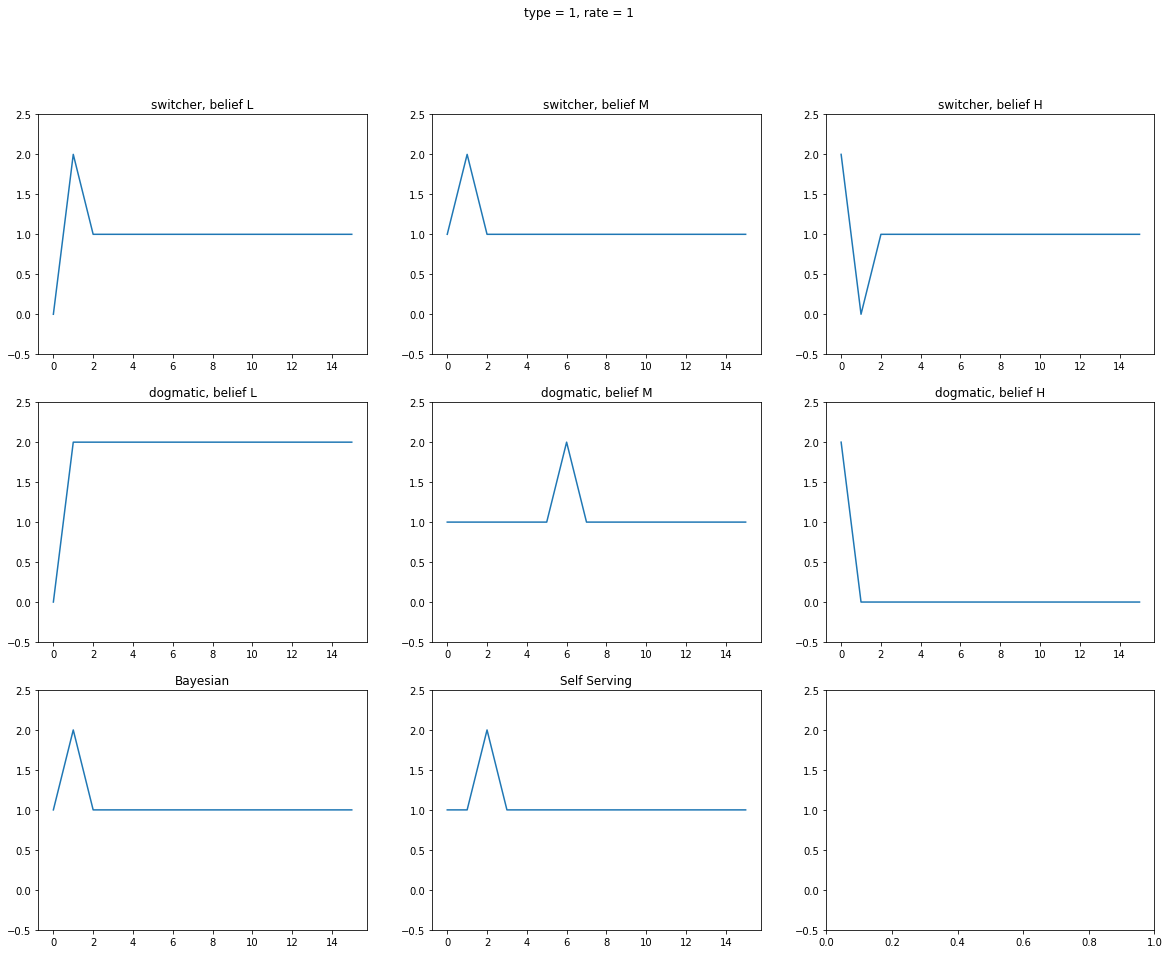

In [574]:
plot(choices_11, 1, 1)


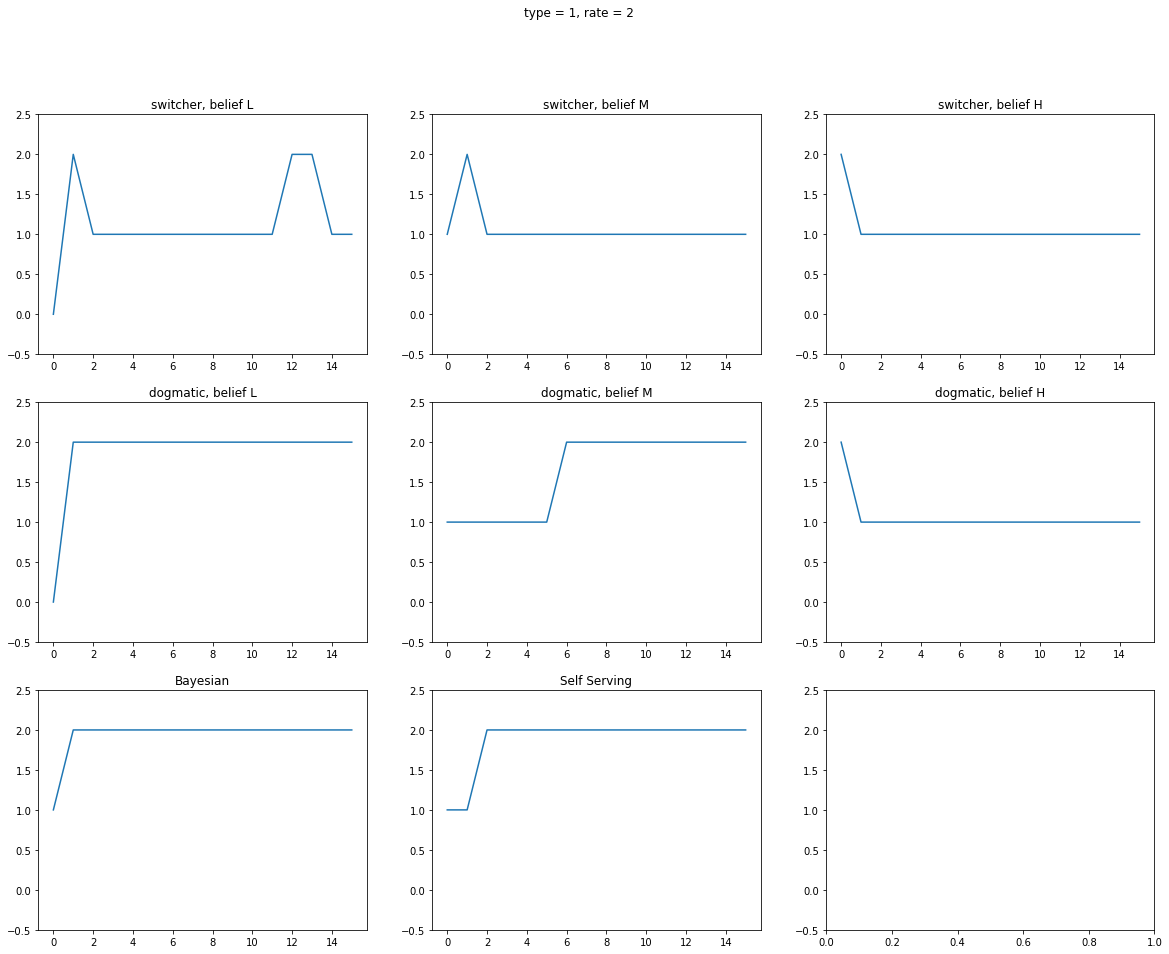

In [575]:
plot(choices_12, 1, 2)



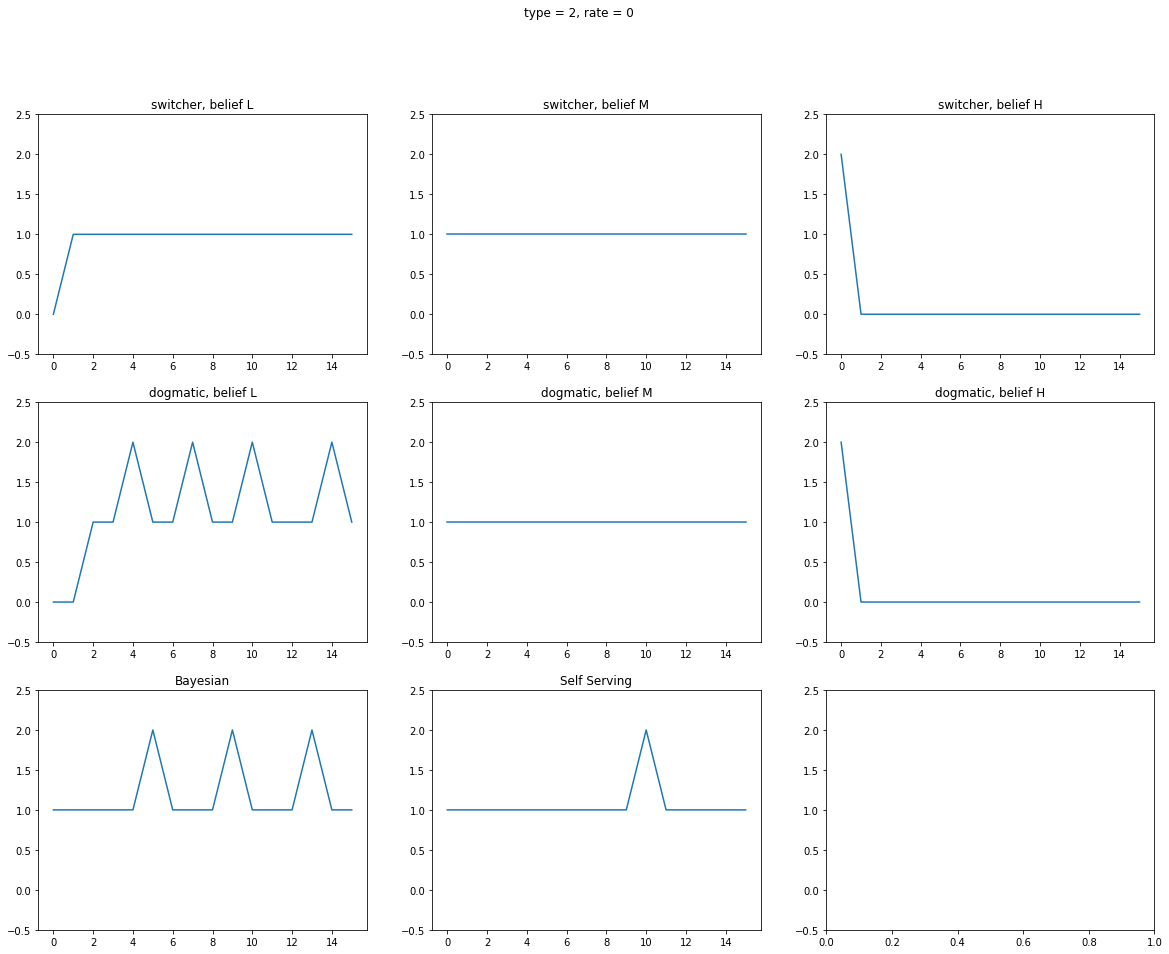

In [576]:
plot(choices_20, 2, 0)


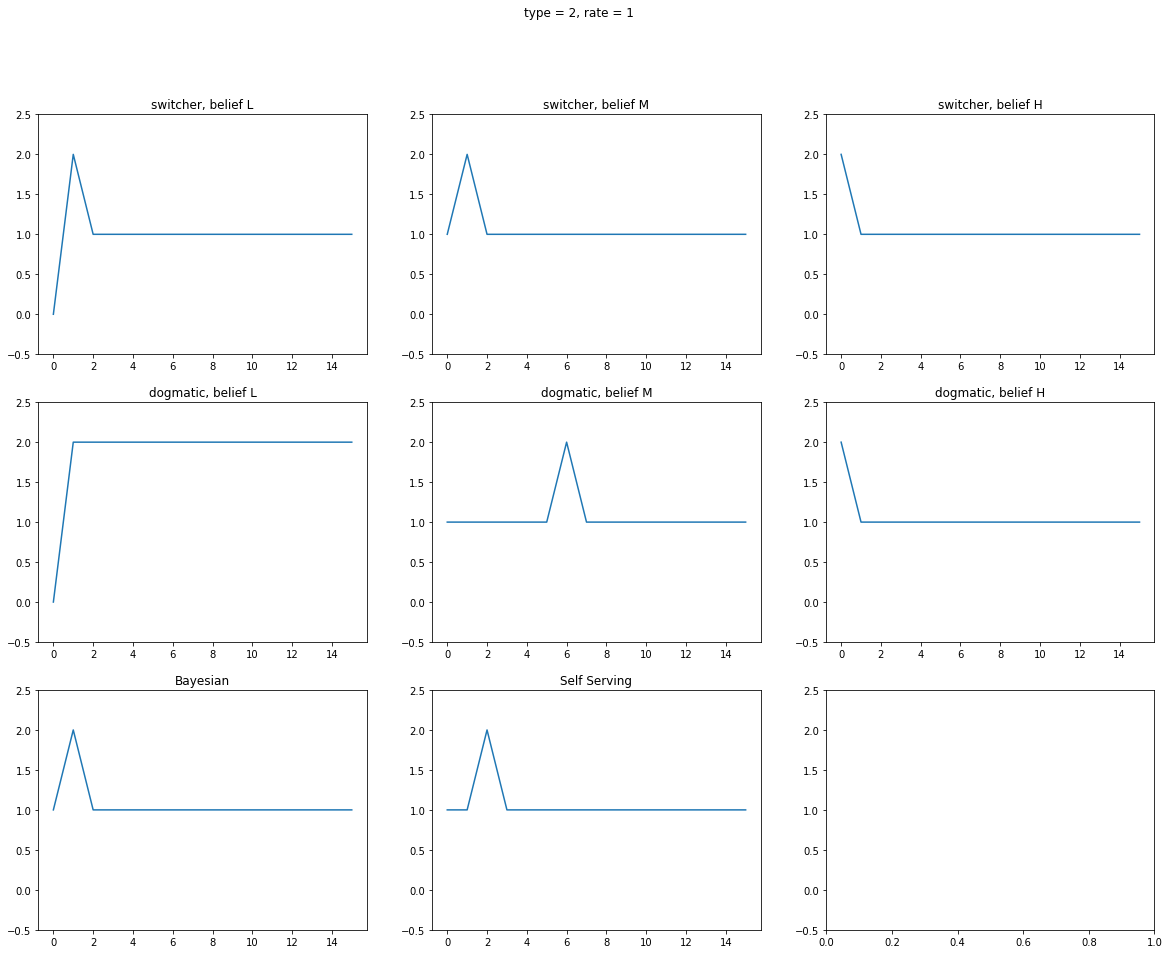

In [577]:
plot(choices_21, 2, 1)


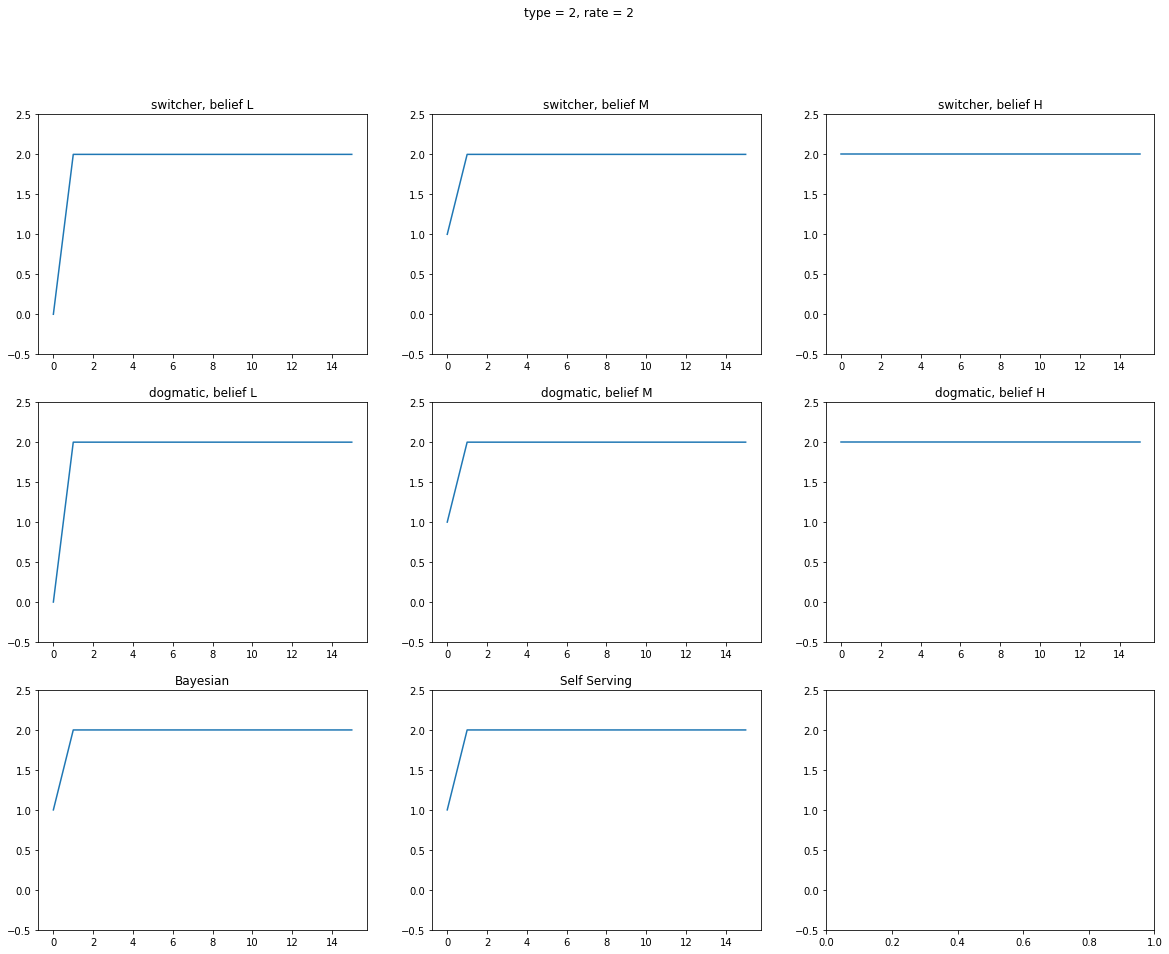

In [578]:
plot(choices_22, 2, 2)

In [590]:
# create a grid of parameters for the self-attribution bias (no base rate neglect yet)
values_c = np.linspace(0, 2, num=20)



In [598]:
## simulate the self-attribution bias for all the  parameters
def simulate_ss_grid(theta, omega, p0_theta, p0_omega, M, c, d, T, N, trials, seeds, a):
    
    ###### Determine the outcomes beforehand
    # set a seed for each type
    rng_H = np.random.default_rng(seed=seeds[0])
    rng_M = np.random.default_rng(seed=seeds[1])
    rng_L = np.random.default_rng(seed=seeds[2])

    #############
    # generate all the draws for T periods for each type and for each effort choice
    ############

    ##### for the high types
    # outcomes after choosing L
    outcome_H_L = rng_H.binomial(1, M[2][0, omega], size=(T, be_trials))
    # outcomes after choosing M
    outcome_H_M = rng_H.binomial(1, M[2][1, omega], size=(T, be_trials))
    # outcomes after choosing H
    outcome_H_H = rng_H.binomial(1, M[2][2, omega], size=(T, be_trials))

    ##### for the medium types
    # after low effort
    outcome_M_L = rng_M.binomial(1, M[1][0, omega], size=(T, be_trials))
    # after medium effort
    outcome_M_M = rng_M.binomial(1, M[1][1, omega], size=(T, be_trials))
    # after high effort
    outcome_M_H = rng_M.binomial(1, M[1][2, omega], size=(T, be_trials))

    #### for the low types
    outcomes_L_L = rng_L.binomial(1, M[0][0, omega], size=(T, be_trials))
    outcomes_L_M = rng_L.binomial(1, M[0][1, omega], size=(T, be_trials))
    outcomes_L_H = rng_L.binomial(1, M[0][2, omega], size=(T, be_trials))

    # stack the outcome vectors foe each type into a matrix. first element is the effort choice, secod is t
    outcomes_H = np.stack((outcome_H_L, outcome_H_M, outcome_H_H))
    outcomes_M = np.stack((outcome_M_L, outcome_M_M, outcome_M_H))
    outcomes_L = np.stack((outcomes_L_L, outcomes_L_M, outcomes_L_H))

    # stack all the matrices into a single outcomes matrix of matrices
    outcomes = np.stack((outcomes_L, outcomes_M, outcomes_H))
    
    
    #############
    # set empty vectors where all the data will be saved period by period for each of the models
    ############
    # beliefs
    
    p_theta_ss =[p0_theta]
    p_omega_ss = [p0_omega]
    
    # choices
    
    e_ss = [choice_bay(p0_theta, p0_omega, M)]
    
    signals = outcomes[theta]
    
    for t in range(T):
        # get the signals
        signal_ss = signals[e_ss[t], omega]
        
        # update beliefs
        ss_theta, ss_omega, ss_lr = bayes_biases(c, d, p_theta_ss[t], p_omega_ss[t], signal_ss, M, e_ss[t])
        p_theta_ss.append(ss_theta)
        p_omega_ss.append(ss_omega)
        
        # Choices
        e_ss_t = choice_bay(ss_theta, ss_omega, M)
        e_ss.append(e_ss_t)
        
    return e_ss, ss_theta, signals

In [600]:
for c in np.transpose(C):
    print(c)

[0. 0. 0. 0.]
[0.10526316 0.10526316 0.10526316 0.10526316]
[0.21052632 0.21052632 0.21052632 0.21052632]
[0.31578947 0.31578947 0.31578947 0.31578947]
[0.42105263 0.42105263 0.42105263 0.42105263]
[0.52631579 0.52631579 0.52631579 0.52631579]
[0.63157895 0.63157895 0.63157895 0.63157895]
[0.73684211 0.73684211 0.73684211 0.73684211]
[0.84210526 0.84210526 0.84210526 0.84210526]
[0.94736842 0.94736842 0.94736842 0.94736842]
[1.05263158 1.05263158 1.05263158 1.05263158]
[1.15789474 1.15789474 1.15789474 1.15789474]
[1.26315789 1.26315789 1.26315789 1.26315789]
[1.36842105 1.36842105 1.36842105 1.36842105]
[1.47368421 1.47368421 1.47368421 1.47368421]
[1.57894737 1.57894737 1.57894737 1.57894737]
[1.68421053 1.68421053 1.68421053 1.68421053]
[1.78947368 1.78947368 1.78947368 1.78947368]
[1.89473684 1.89473684 1.89473684 1.89473684]
[2. 2. 2. 2.]
